In [642]:
import numpy as np
import matplotlib.pyplot as plt

In [643]:
def progonka(mat: np.matrix, vals: np.array):
    n = len(vals)

    a = np.array([mat[0, 1] / mat[0, 0]])
    b = np.array([vals[0] / mat[0, 0]])

    for i in range(1, n):
        y = mat[i, i] + mat[i, i - 1] * a[len(a) - 1]

        if i < n -1:
            a = np.append(a, - mat[i, i + 1] / y)
        b = np.append(b, (vals[i] - mat[i, i - 1] * b[len(b) - 1]) / y)

    res = np.array([b[len(b) - 1]])
    for i in range(n - 2, -1, -1):
        res = np.append(res, a[i] * res[len(res) - 1] + b[i])

    return res

In [644]:
def splain_3_interpolant(x_points, x_nodes, y_nodes):
    n = len(x_nodes) - 1

    h = np.array([x_nodes[i + 1] - x_nodes[i] if (x_nodes[i + 1] - x_nodes[i] != 0) else 0.000000000000001 for i in range(n)])

    mat = np.matrix(
        [([1.] + [0.] * n)] +

        [[0.] * (i - 1) +
         [h[i - 1]] + [2. * (h[i]+h[i - 1])] + [h[i]] +
         [0.] * (n - i - 1) for i in range(1, n)] +

        [([0.] * n + [1.])]
    )

    vals = np.array([0.] +
        [3. / h[i] * (y_nodes[i + 1] - y_nodes[i]) - 3. / h[i - 1] * (y_nodes[i] - y_nodes[i - 1]) for i in range(1, n)] +
    [0.])

    c = progonka(mat, vals)

    b = []
    for i in range(n):
        b.append(1 / h[i] * (y_nodes[i + 1] - y_nodes[i]) - h[i] / 3 * (c[i + 1] + 2 * c[i]))

    d = []
    for i in range(n):
        d.append((c[i + 1] - c[i]) / (3 * h[i]))

    points = []
    # for point in x_points:
    #     for i in range(n):
    #         if (x_nodes[i] <= point <= x_nodes[i + 1]) or (x_nodes[i] >= point >= x_nodes[i + 1]):
    #             points.append((point, y_nodes[i] + b[i] * (point - x_nodes[i]) + c[i] * (point - x_nodes[i])**2 + d[i] * (point - x_nodes[i])**3))
    #             break

    for i in range(n):
        for point in np.arange(x_nodes[i], x_nodes[i + 1], (x_nodes[i + 1] - x_nodes[i]) / 100.):
            points.append((point, y_nodes[i] + b[i] * (point - x_nodes[i]) + c[i] * (point - x_nodes[i])**2 + d[i] * (point - x_nodes[i])**3))

    return points


In [645]:
def data_plot_with_interpolant(x_nodes, y_nodes, method):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    x_for_plotting = np.arange(min(x_nodes), max(x_nodes), 0.0001)
    ax.plot(x_nodes, y_nodes, 'ro', markersize=10)

    points = method(x_for_plotting, x_nodes, y_nodes)
    print(points)
    x_points = list(map(lambda x: x[0], points))
    y_points = list(map(lambda x: x[1], points))
    ax.plot(x_points, y_points, 'g-', linewidth=4)
    ax.grid()

In [646]:
def get_points_from_file(filename: str):
    f = open(filename, 'r')
    return list(map(lambda x: tuple(map(float, x.split(' '))), f.readlines()))

In [647]:
def lab1_base(filename_in: str, factor:int, filename_out:str):
    points = get_points_from_file(filename_in)[:5]
    n = len(points)

    x_nodes = [points[i][0] * 100 for i in range(0, n, 1)]
    y_nodes = [points[i][1] * 100 for i in range(0, n, 1)]

    data_plot_with_interpolant(x_nodes, y_nodes, splain_3_interpolant)


ZeroDivisionError: float division by zero

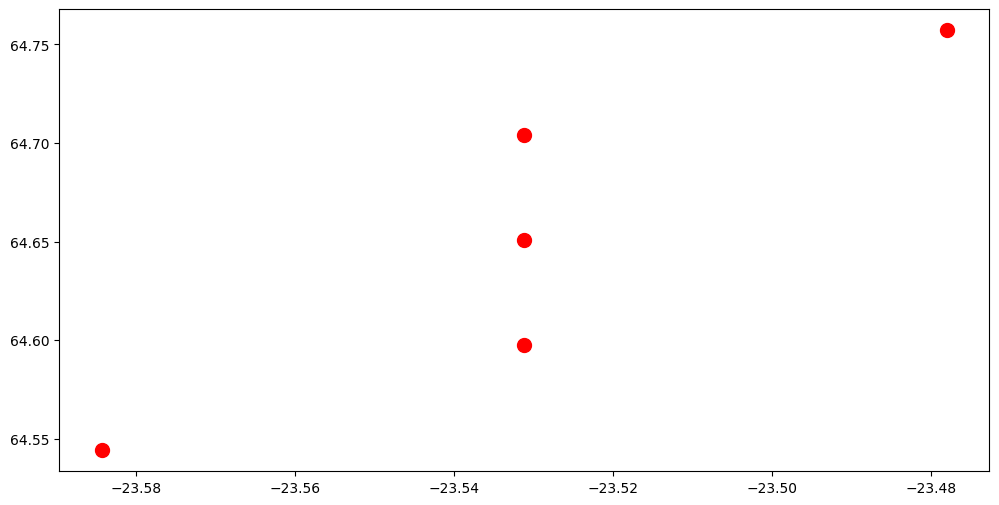

In [648]:
lab1_base('contour.txt', 10, '')